# Imports

In [1]:
import json
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch

from s4hci.utils.data_handling import load_adi_data, save_as_fits
from s4hci.models.psf_subtraction import S4
from s4hci.models.noise import S4Noise
from s4hci.utils.s4_rigde import compute_betas_svd, compute_betas_least_square

# Load a dataset which has problems with numerical stability

In [2]:
print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = load_adi_data(
    "/fast/mbonse/s4/30_data/HD22049_310_0100_C-0656_A_.hdf5",
    data_tag="object",
    psf_template_tag="psf_template",
    para_tag="header_object/PARANG") 

print("[DONE]")

Loading data ... [DONE]


In [3]:
science_data = science_data[:, 12:-12, 12:-12] 
psf_template = np.median(raw_psf_template_data, axis=0)
psf_template = psf_template - np.min(psf_template)

## Create a test S4 model

In [4]:
s4_model = S4(
    data_cube=science_data,
    parang=raw_angles,
    psf_template=psf_template,
    noise_noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_lambda_init=1e3,
    planet_convolve_second=True,
    planet_use_up_sample=1,
    work_dir=Path("/fast/mbonse/s4/70_results/03_contrast_grid/debug_numerics/"),
    verbose=True)

Creating right reason mask ... [DONE]


In [5]:
x_train = torch.from_numpy(science_data).float()

In [6]:
s4_model.noise_model._prepare_normalization(x_train)

Build normalization frames ... [DONE]


In [7]:
science_data_norm = s4_model.noise_model.normalize_data(x_train)

In [8]:
X_torch = science_data_norm
M_torch = s4_model.noise_model.right_reason_mask
positions = [(40, 50), (40, 40)]
p_torch = s4_model.noise_model.psf_model
verbose=True,
device=0

# Compute beta svd

In [31]:
betas_svd = compute_betas_svd(
        X_torch=X_torch,
        M_torch=M_torch,
        lambda_regs=[100, 1000, 2000, 10000],
        positions=positions,
        p_torch=p_torch,
        approx_svd=-1,
        verbose=True,
        device=device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:07<00:00, 67.11s/it]


In [355]:
betas_lsqr = compute_betas_least_square(
        X_torch=X_torch.float(),
        M_torch=M_torch.float(),
        lambda_reg=10000,
        positions=positions,
        p_torch=p_torch.float(),
        verbose=True,
        device=device)[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]


In [356]:
betas_lsqr_cut = betas_lsqr * M_torch[40 * image_size + 50].flatten()

betas_lsqr_conv = F.conv2d(
    betas_lsqr_cut.reshape(1, 1, 117, 117),
    p_torch, padding="same")

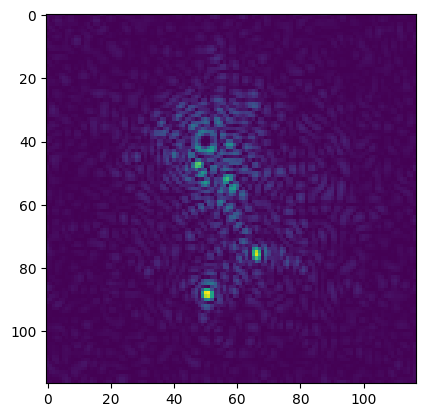

In [357]:
plt.imshow(betas_lsqr_conv.reshape(117, 117).abs())

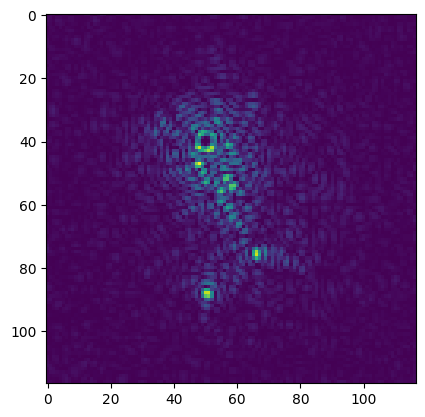

In [98]:
plt.imshow(betas_svd[0, 2].abs())

# Compute beta least squares

In [9]:
import torch
import torch.nn.functional as F

In [10]:
X_torch = X_torch.unsqueeze(1)
image_size = X_torch.shape[-1]

# convolve the data on the GPU
X_torch = X_torch.to(device)

In [11]:
X_conv = F.conv2d(
    X_torch,
    p_torch.to(device),
    padding="same")

X_torch = X_torch.cpu()
X_conv = X_conv.view(X_torch.shape[0], -1)

In [12]:
#time_normalization = torch.mean(torch.abs(X_conv), axis=0)
#X_conv = X_conv / time_normalization

In [13]:
#plt.plot(time_normalization.cpu())
#plt.xlim(0, 1000)

In [56]:
lambda_reg = 2000

In [75]:
# double
X_conv_square = (X_conv.T.double() @ X_conv.double()).float()

In [60]:
# fp32
X_conv_square = X_conv.T @ X_conv

In [76]:
tmp_idx = 40 * image_size + 50

# get the current mask
m_torch = M_torch[tmp_idx].flatten().to(device)
Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx].to(device)

# set up the least square problem
lhs = ((X_conv_square * m_torch).T * m_torch).T + \
      torch.eye(
          image_size ** 2,
          image_size ** 2,
          device=X_conv_square.device) * lambda_reg

rhs = (X_conv * m_torch).T @ Y_torch

In [59]:
torch.linalg.cond(lhs)

tensor(7.5200e+10, device='cuda:0')

In [62]:
torch.linalg.cond(lhs)

tensor(2.7470e+12, device='cuda:0')

In [91]:
beta = torch.linalg.lstsq(lhs.double(), rhs.view(-1, 1).double())

In [92]:
beta_final = torch.stack(
    [beta.solution.squeeze().float(), ]).reshape(
        1, image_size**2).to(M_torch.device).reshape(117, 117)

In [93]:
beta_final_cut = beta_final * M_torch[tmp_idx]

In [94]:
tmp_weights2 = F.conv2d(
    beta_final_cut.reshape(1, 1, 117, 117).cuda(),
    p_torch.to(device),
    padding="same").view(117, 117)

In [96]:
tmp_weights1 - tmp_weights2

tensor([[ 2.0547e-03,  1.9796e-03,  2.2032e-03,  ..., -5.0748e-04,
          1.1828e-04,  9.5123e-04],
        [-1.3561e-03, -1.3796e-03, -2.0202e-04,  ..., -7.0459e-04,
         -2.4049e-04,  9.7921e-05],
        [-1.6396e-03, -1.0553e-03,  5.8330e-04,  ..., -3.3883e-04,
         -3.5550e-04, -1.3025e-05],
        ...,
        [-2.4481e-05, -1.2346e-05, -1.8666e-05,  ..., -4.7311e-05,
         -2.1511e-05,  1.0827e-05],
        [-8.1110e-06,  3.0963e-06, -4.5268e-07,  ..., -4.5456e-05,
         -1.5388e-05,  1.3444e-05],
        [-2.6105e-05, -2.2463e-05, -3.0278e-05,  ..., -7.0172e-06,
          1.8185e-06,  1.6744e-06]], device='cuda:0')

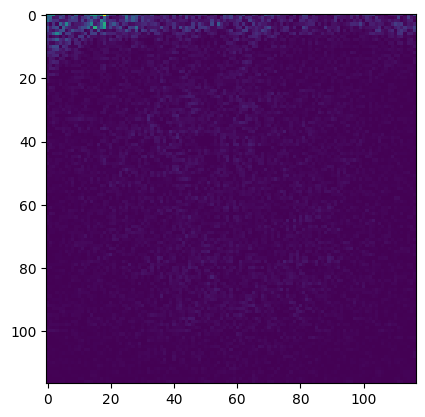

In [97]:
plt.imshow((tmp_weights1-tmp_weights2).squeeze().cpu().abs())

In [104]:
((tmp_weights1-tmp_weights2).abs() / tmp_weights2.abs())

tensor([[2.9307e+00, 1.7851e+00, 3.0071e+00,  ..., 8.2611e-01, 2.0152e-01,
         8.1943e-01],
        [9.8102e-01, 1.1713e+00, 4.8190e+00,  ..., 4.5527e+00, 5.0709e-01,
         2.2348e-01],
        [1.2659e+00, 1.1674e+00, 1.1004e+00,  ..., 1.7102e+00, 1.9618e+00,
         2.8004e-02],
        ...,
        [5.7983e-02, 3.4022e-02, 2.6657e-02,  ..., 2.7444e-01, 3.6585e-02,
         7.6074e-03],
        [3.4693e-02, 1.7336e-02, 2.3141e-03,  ..., 1.0033e-01, 1.6527e-02,
         9.2194e-03],
        [3.0518e-02, 2.7216e-02, 7.7816e-02,  ..., 1.2055e-02, 2.6308e-03,
         1.7203e-03]], device='cuda:0')